# Estimating Obesity Levels Based on Eating Habits and Physical Activity  
**Capstone Project 2 by [Adi Kusuma] - [DataTalks.Club](https://datatalks.club)**  

Obesity is a growing global health issue. Understanding an individual's eating habits and physical activity levels can provide valuable insights into their overall health. Poor diet and lack of exercise are significant factors contributing to severe obesity, which can lead to serious health risks.  

In this project, I analyzed data from individuals in Colombia, Peru, and Mexico. The dataset, sourced from the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition), includes 17 features and 2,111 records. Each record is labeled with the class variable `NObesity` (Obesity Level), which categorizes individuals into the following groups:  
- Insufficient Weight  
- Normal Weight  
- Overweight Level I  
- Overweight Level II  
- Obesity Type I  
- Obesity Type II  
- Obesity Type III  

Notably, **77% of the dataset was synthetically generated** using the Weka tool with the SMOTE filter, while **23% of the data was collected directly** from users via an online platform.  

This project aims to explore how eating habits and physical activity can help estimate obesity levels and provide actionable insights to improve health outcomes.

In [1]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
import os
import re
import numpy as np
import pandas as pd

In [2]:
import os
import requests
import zipfile

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import viridis
from matplotlib.cm import inferno
from matplotlib.cm import plasma
#import mplcyberpunk

#plt.style.use("cyberpunk")

In [4]:
from sklearn.preprocessing import LabelEncoder

In [5]:
import optuna
import warnings

from sklearn.metrics import log_loss

In [6]:
## Set Optuna logging level to WARNING to suppress logs
optuna.logging.set_verbosity(optuna.logging.WARNING)

warnings.filterwarnings("ignore")

In [7]:
# Function to filter positive correlations
#def filter_positive_corr(df, threshold=0.5):
def filter_positive_corr(df, threshold):
    """
    Calculate the correlations between numerical columns in the DataFrame and
    display column pairs with positive correlations greater than the threshold.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        threshold (float): The positive correlation threshold (default: 0.5).

    Returns:
        pd.DataFrame: DataFrame containing column pairs with positive correlation > threshold.
    """
    # Select numerical columns
    numeric_df = df.select_dtypes(include=['number'])

    # Compute the correlation matrix
    corr_matrix = numeric_df.corr()

    # Create a DataFrame for column pairs with positive correlation > threshold
    corr_pairs = (
        corr_matrix
        .where(lambda x: x > threshold)  # Select positive correlations > threshold
        .stack()                         # Convert the matrix into column pairs
        .reset_index()                   # Reset index to create a DataFrame
        .rename(columns={0: 'Correlation', 'level_0': 'Feature 1', 'level_1': 'Feature 2'})
    )

    # Remove correlations between the same columns
    corr_pairs = corr_pairs[corr_pairs['Feature 1'] != corr_pairs['Feature 2']]

    # Remove duplicate column pairs (Feature 1, Feature 2) and (Feature 2, Feature 1)
    corr_pairs['Ordered Pair'] = corr_pairs[['Feature 1', 'Feature 2']].apply(lambda x: tuple(sorted(x)), axis=1)
    corr_pairs = corr_pairs.drop_duplicates(subset='Ordered Pair').drop(columns='Ordered Pair')

    return corr_pairs.sort_values(by='Correlation', ascending=False)

# Function to filter negative correlations
#def filter_negative_corr(df, threshold=-0.5):
def filter_negative_corr(df, threshold):
    """
    Calculate the correlations between numerical columns in the DataFrame and
    display column pairs with negative correlations smaller than the threshold.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        threshold (float): The negative correlation threshold (default: -0.5).

    Returns:
        pd.DataFrame: DataFrame containing column pairs with negative correlation < threshold.
    """
    # Select numerical columns
    numeric_df = df.select_dtypes(include=['number'])

    # Compute the correlation matrix
    corr_matrix = numeric_df.corr()

    # Create a DataFrame for column pairs with negative correlation < threshold
    corr_pairs = (
        corr_matrix
        .where(lambda x: x < threshold)  # Select negative correlations < threshold
        .stack()                         # Convert the matrix into column pairs
        .reset_index()                   # Reset index to create a DataFrame
        .rename(columns={0: 'Correlation', 'level_0': 'Feature 1', 'level_1': 'Feature 2'})
    )

    # Remove correlations between the same columns
    corr_pairs = corr_pairs[corr_pairs['Feature 1'] != corr_pairs['Feature 2']]

    # Remove duplicate column pairs (Feature 1, Feature 2) and (Feature 2, Feature 1)
    corr_pairs['Ordered Pair'] = corr_pairs[['Feature 1', 'Feature 2']].apply(lambda x: tuple(sorted(x)), axis=1)
    corr_pairs = corr_pairs.drop_duplicates(subset='Ordered Pair').drop(columns='Ordered Pair')

    return corr_pairs.sort_values(by='Correlation')

In [8]:
def positive_correlations(df, target_column, threshold):
    """
    Displays positive correlations greater than the threshold with the target_column, only for numeric columns
    and ignoring correlations with the column itself.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        target_column (str): The target column to calculate correlations with.
        threshold (float): The minimum correlation threshold for positive correlations.

    Returns:
        pd.Series: Positive correlations greater than the threshold.
    """
    # Ensure the target column exists and is numeric
    if target_column not in df.columns:
        raise ValueError(f"Column '{target_column}' not found in the DataFrame.")
    if not pd.api.types.is_numeric_dtype(df[target_column]):
        raise TypeError(f"Column '{target_column}' must be numeric.")
    
    # Filter numeric columns and calculate correlations
    numeric_df = df.select_dtypes(include=['number'])  # Only numeric columns
    correlations = numeric_df.corr()[target_column].sort_values(ascending=False)
    
    # Filter positive correlations greater than the threshold (excluding the column itself)
    return correlations[(correlations > threshold) & (correlations.index != target_column)]


In [9]:
def negative_correlations(df, target_column, threshold):
    """
    Displays negative correlations less than the threshold with the target_column, only for numeric columns
    and ignoring correlations with the column itself.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        target_column (str): The target column to calculate correlations with.
        threshold (float): The maximum correlation threshold for negative correlations.

    Returns:
        pd.Series: Negative correlations less than the threshold.
    """
    # Ensure the target column exists and is numeric
    if target_column not in df.columns:
        raise ValueError(f"Column '{target_column}' not found in the DataFrame.")
    if not pd.api.types.is_numeric_dtype(df[target_column]):
        raise TypeError(f"Column '{target_column}' must be numeric.")
    
    # Filter numeric columns and calculate correlations
    numeric_df = df.select_dtypes(include=['number'])  # Only numeric columns
    correlations = numeric_df.corr()[target_column].sort_values(ascending=True)
    
    # Filter negative correlations less than the threshold (excluding the column itself)
    return correlations[(correlations < threshold) & (correlations.index != target_column)]


In [10]:
def summarize_dataframe_20(df):
    """
    Membuat ringkasan informasi untuk DataFrame.
    
    Parameter:
        df (pd.DataFrame): DataFrame yang akan dirangkum.
    
    Returns:
        pd.DataFrame: DataFrame berisi ringkasan kolom, jumlah nilai unik, daftar nilai unik
                      (maksimum 20 nilai), jumlah NaN, persentase NaN, dan statistik value counts.
    """
    # Hitung jumlah nilai unik untuk setiap kolom
    nunique_values = df.nunique()

    # Buat daftar nilai unik (maksimum 20 nilai) untuk setiap kolom
    unique_values = [
        ', '.join(map(str, df[col].unique()[:20])) + ('...' if nunique_values[col] > 20 else '')
        for col in df.columns
    ]

    # Hitung jumlah nilai NaN untuk setiap kolom
    count_nan = df.isna().sum()

    # Hitung persentase nilai NaN untuk setiap kolom
    nan_percentage = (count_nan / len(df)) * 100
    
    # Ambil tipe data untuk setiap kolom
    dtype_values = df.dtypes

    # Hitung value_counts (maksimum 20 nilai) dan value_counts(normalize=True)
    value_counts_dict = {
        col: {k: v for k, v in list(df[col].value_counts().items())[:20]} for col in df.columns
    }
    value_counts_norm_dict = {
        col: {k: round(v, 3) for k, v in list(df[col].value_counts(normalize=True).items())[:20]} for col in df.columns
    }

    # Buat DataFrame ringkasan
    df_summary = pd.DataFrame({
        'columns': df.columns,
        'nunique': nunique_values.values,
        'unique (max 20)': unique_values,
        'len_value_counts': [len(df[col].value_counts()) for col in df.columns],  # Jumlah unique values per kolom
        'value_counts (max 20)': [value_counts_dict[col] for col in df.columns],
        'value_counts_norm (max 20)': [value_counts_norm_dict[col] for col in df.columns],
        'dtype': dtype_values.values,
        'count_nan': count_nan.values,
        'nan_percentage': nan_percentage.values,
    })
    
    return df_summary


In [11]:
def set_pandas_display_options():
    """
    Set pandas display options to show full text in columns, 
    display all columns, prevent line wrapping, and show all rows.
    """
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_rows', None)
    print("Pandas display options set all.")

def reset_pandas_display_options():
    """
    Reset pandas display options to their default values.
    """
    pd.reset_option('display.max_colwidth')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.max_rows')
    print("Pandas display options reset all to default.")


# Download dataset

In [12]:
# Define the URL of the CSV file
url = "https://archive.ics.uci.edu/static/public/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition.zip"

In [13]:
# Check if the file already exists
if os.path.exists("estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.zip"):
    print("estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.zip already exists. Download canceled.")
else:
    # Download the file using requests (more secure and integrated)  
    response = requests.get(url)

    # Check for successful download
    if response.status_code == 200:
        # Write the data to a local ZIP file
        with open("estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.zip", "wb") as f:
            f.write(response.content)
        print("estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.zip downloaded successfully!")
    else:
        print(f"Error downloading file: {response.status_code}")

estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.zip already exists. Download canceled.


In [14]:
# Define the directory where the files will be extracted
extract_dir = "estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition"

# Check if the directory already exists
if not os.path.exists(extract_dir):
    # Unzip the file only if the directory doesn't exist
    with zipfile.ZipFile("estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.zip", "r") as zip_ref:
        zip_ref.extractall(extract_dir)
        print(f"Files extracted to '{extract_dir}' directory.")
        print("Files extracted:", zip_ref.namelist())
else:
    print(f"Directory '{extract_dir}' already exists. Skipping extraction.")

Directory 'estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition' already exists. Skipping extraction.


# Feature description

| Variable Name                 | Role     | Type         | Demographic    | Description                                                                                 | Units | Missing Values |
|-------------------------------|----------|--------------|----------------|---------------------------------------------------------------------------------------------|-------|----------------|
| Gender                        | Feature  | Categorical  | Gender         |                                                                                             |       | no             |
| Age                           | Feature  | Continuous   | Age            |                                                                                             |       | no             |
| Height                        | Feature  | Continuous   |                |                                                                                             |       | no             |
| Weight                        | Feature  | Continuous   |                |                                                                                             |       | no             |
| family_history_with_overweight| Feature  | Binary       |                | Has a family member suffered or suffers from overweight?                                    |       | no             |
| FAVC                          | Feature  | Binary       |                | Do you eat high caloric food frequently?                                                   |       | no             |
| FCVC                          | Feature  | Integer      |                | Do you usually eat vegetables in your meals?                                               |       | no             |
| NCP                           | Feature  | Continuous   |                | How many main meals do you have daily?                                                     |       | no             |
| CAEC                          | Feature  | Categorical  |                | Do you eat any food between meals?                                                         |       | no             |
| SMOKE                         | Feature  | Binary       |                | Do you smoke?                                                                               |       | no             |
| CH2O                          | Feature  | Continuous   |                | How much water do you drink daily?                                                         |       | no             |
| SCC                           | Feature  | Binary       |                | Do you monitor the calories you eat daily?                                                 |       | no             |
| FAF                           | Feature  | Continuous   |                | How often do you have physical activity?                                                   |       | no             |
| TUE                           | Feature  | Integer      |                | How much time do you use technological devices such as cell phone, videogames, television, computer and others? |       | no             |
| CALC                          | Feature  | Categorical  |                | How often do you drink alcohol?                                                            |       | no             |
| MTRANS                        | Feature  | Categorical  |                | Which transportation do you usually use?                                                   |       | no             |
| NObeyesdad                    | Target   | Categorical  |                | Obesity level                                                                              |       | no             |


# Loading the dataset

In [15]:
df = pd.read_csv("estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition/ObesityDataSet_raw_and_data_sinthetic.csv")
df.sample(5)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
1917,Female,21.768153,1.764160,133.888629,yes,yes,3.0,3.0,Sometimes,no,2.325020,no,1.441791,0.918468,Sometimes,Public_Transportation,Obesity_Type_III
1970,Female,25.908829,1.607734,102.305767,yes,yes,3.0,3.0,Sometimes,no,1.030501,no,0.065820,0.991473,Sometimes,Public_Transportation,Obesity_Type_III
1928,Female,26.000000,1.652674,111.919155,yes,yes,3.0,3.0,Sometimes,no,2.814517,no,0.000000,0.101598,Sometimes,Public_Transportation,Obesity_Type_III
1913,Female,26.000000,1.631547,111.588625,yes,yes,3.0,3.0,Sometimes,no,2.554007,no,0.000000,0.252635,Sometimes,Public_Transportation,Obesity_Type_III
495,Male,19.000000,1.800000,60.000000,yes,yes,3.0,1.0,Always,no,1.000000,yes,0.000000,0.000000,no,Motorbike,Normal_Weight


# Exploratory data analysis (EDA)

## Renaming the columns

In [16]:
df.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

In [17]:
df.rename(columns={
    'family_history_with_overweight': 'Family_History_Overweight',
    'FAVC': 'High_Caloric_Food',
    'FCVC': 'Vegetable_Consumption',
    'NCP': 'Main_Meals_Per_Day',
    'CAEC': 'Snacking_Between_Meals',
    'SMOKE': 'Smoking',
    'CH2O': 'Water_Intake',
    'SCC': 'Calorie_Monitoring',
    'FAF': 'Physical_Activity_Frequency',
    'TUE': 'Tech_Usage_Hours',
    'CALC': 'Alcohol_Consumption',
    'MTRANS': 'Transportation_Mode',
    'NObeyesdad': 'Obesity_Level'
}, inplace=True)


In [18]:
df.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'Family_History_Overweight',
       'High_Caloric_Food', 'Vegetable_Consumption', 'Main_Meals_Per_Day',
       'Snacking_Between_Meals', 'Smoking', 'Water_Intake',
       'Calorie_Monitoring', 'Physical_Activity_Frequency', 'Tech_Usage_Hours',
       'Alcohol_Consumption', 'Transportation_Mode', 'Obesity_Level'],
      dtype='object')

In [19]:
df.columns = df.columns.str.lower()


In [20]:
df.columns

Index(['gender', 'age', 'height', 'weight', 'family_history_overweight',
       'high_caloric_food', 'vegetable_consumption', 'main_meals_per_day',
       'snacking_between_meals', 'smoking', 'water_intake',
       'calorie_monitoring', 'physical_activity_frequency', 'tech_usage_hours',
       'alcohol_consumption', 'transportation_mode', 'obesity_level'],
      dtype='object')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gender                       2111 non-null   object 
 1   age                          2111 non-null   float64
 2   height                       2111 non-null   float64
 3   weight                       2111 non-null   float64
 4   family_history_overweight    2111 non-null   object 
 5   high_caloric_food            2111 non-null   object 
 6   vegetable_consumption        2111 non-null   float64
 7   main_meals_per_day           2111 non-null   float64
 8   snacking_between_meals       2111 non-null   object 
 9   smoking                      2111 non-null   object 
 10  water_intake                 2111 non-null   float64
 11  calorie_monitoring           2111 non-null   object 
 12  physical_activity_frequency  2111 non-null   float64
 13  tech_usage_hours  

## Dropping duplicated

In [22]:
df.duplicated().sum()

24

In [23]:
df = df.drop_duplicates()
df.duplicated().sum()

0

## Summary dataframe

In [24]:
set_pandas_display_options()

Pandas display options set all.


In [25]:
# Contoh penggunaan
df_summary = summarize_dataframe_20(df)
# Hapus baris dengan nilai 'ID' pada kolom 'columns'
#df_summary = df_summary[df_summary['columns'] != 'ID']
# Menyaring DataFrame agar kolom 'columns' tidak mengandung nilai tertentu
#df_summary = df_summary[~df_summary['columns'].isin(['efs_time', 'donor_age', 'age_at_hct'])]
# print(df_summary)
#df_summary

In [26]:
# Sort df_summary by the 'dtype' column in ascending order
df_summary = df_summary.sort_values(by='dtype', ascending=True)
df_summary

,columns,nunique,unique (max 20),len_value_counts,value_counts (max 20),value_counts_norm (max 20),dtype,count_nan,nan_percentage
1,age,1402,"21.0, 23.0, 27.0, 22.0, 29.0, 24.0, 26.0, 41.0, 30.0, 52.0, 20.0, 19.0, 31.0, 39.0, 17.0, 25.0, 55.0, 38.0, 18.0, 15.0...",1402,"{18.0: 126, 26.0: 101, 23.0: 89, 21.0: 78, 19.0: 59, 20.0: 48, 22.0: 37, 17.0: 30, 24.0: 18, 25.0: 15, 27.0: 14, 33.0: 13, 29.0: 11, 16.0: 8, 30.0: 8, 41.0: 7, 38.0: 7, 40.0: 6, 34.0: 5, 31.0: 4}","{18.0: 0.06, 26.0: 0.048, 23.0: 0.043, 21.0: 0.037, 19.0: 0.028, 20.0: 0.023, 22.0: 0.018, 17.0: 0.014, 24.0: 0.009, 25.0: 0.007, 27.0: 0.007, 33.0: 0.006, 29.0: 0.005, 16.0: 0.004, 30.0: 0.004, 41.0: 0.003, 38.0: 0.003, 40.0: 0.003, 34.0: 0.002, 31.0: 0.002}",float64,0,0.0
2,height,1574,"1.62, 1.52, 1.8, 1.78, 1.5, 1.64, 1.72, 1.85, 1.65, 1.77, 1.7, 1.93, 1.53, 1.71, 1.69, 1.6, 1.75, 1.68, 1.58, 1.79...",1574,"{1.7: 60, 1.65: 50, 1.6: 43, 1.75: 39, 1.8: 28, 1.62: 21, 1.72: 18, 1.63: 17, 1.67: 16, 1.78: 15, 1.56: 14, 1.74: 14, 1.55: 14, 1.66: 13, 1.68: 13, 1.76: 13, 1.85: 13, 1.5: 13, 1.64: 10, 1.69: 9}","{1.7: 0.029, 1.65: 0.024, 1.6: 0.021, 1.75: 0.019, 1.8: 0.013, 1.62: 0.01, 1.72: 0.009, 1.63: 0.008, 1.67: 0.008, 1.78: 0.007, 1.56: 0.007, 1.74: 0.007, 1.55: 0.007, 1.66: 0.006, 1.68: 0.006, 1.76: 0.006, 1.85: 0.006, 1.5: 0.006, 1.64: 0.005, 1.69: 0.004}",float64,0,0.0
3,weight,1525,"64.0, 56.0, 77.0, 87.0, 89.8, 53.0, 55.0, 68.0, 105.0, 80.0, 99.0, 60.0, 66.0, 102.0, 78.0, 82.0, 70.0, 50.0, 65.0, 52.0...",1525,"{80.0: 59, 50.0: 42, 75.0: 39, 60.0: 37, 70.0: 29, 65.0: 25, 90.0: 20, 78.0: 19, 45.0: 18, 85.0: 18, 42.0: 18, 82.0: 17, 56.0: 15, 58.0: 14, 68.0: 14, 55.0: 14, 53.0: 13, 62.0: 11, 83.0: 10, 72.0: 10}","{80.0: 0.028, 50.0: 0.02, 75.0: 0.019, 60.0: 0.018, 70.0: 0.014, 65.0: 0.012, 90.0: 0.01, 78.0: 0.009, 45.0: 0.009, 85.0: 0.009, 42.0: 0.009, 82.0: 0.008, 56.0: 0.007, 58.0: 0.007, 68.0: 0.007, 55.0: 0.007, 53.0: 0.006, 62.0: 0.005, 83.0: 0.005, 72.0: 0.005}",float64,0,0.0
13,tech_usage_hours,1129,"1.0, 0.0, 2.0, 0.29499, 0.838957, 0.479221, 0.62535, 0.26579, 0.555468, 0.928972, 1.340107, 0.58998, 1.37465, 1.283673, 0.062488, 0.9974, 0.738269, 0.860497, 0.478676, 0.555967...",1129,"{0.0: 537, 1.0: 289, 2.0: 108, 0.630866: 4, 1.119877: 3, 0.0026: 3, 0.009254: 2, 0.8324: 2, 1.36595: 2, 0.828549: 2, 1.59257: 2, 0.369134: 2, 1.875023: 2, 0.469735: 2, 0.677909: 2, 0.105895: 2, 1.339232: 2, 0.37465: 2, 1.415536: 2, 0.371941: 2}","{0.0: 0.257, 1.0: 0.138, 2.0: 0.052, 0.630866: 0.002, 1.119877: 0.001, 0.0026: 0.001, 0.009254: 0.001, 0.8324: 0.001, 1.36595: 0.001, 0.828549: 0.001, 1.59257: 0.001, 0.369134: 0.001, 1.875023: 0.001, 0.469735: 0.001, 0.677909: 0.001, 0.105895: 0.001, 1.339232: 0.001, 0.37465: 0.001, 1.415536: 0.001, 0.371941: 0.001}",float64,0,0.0
6,vegetable_consumption,810,"2.0, 3.0, 1.0, 2.450218, 2.880161, 2.00876, 2.596579, 2.591439, 2.392665, 1.123939, 2.027574, 2.658112, 2.88626, 2.714447, 2.750715, 1.4925, 2.205439, 2.059138, 2.310423, 2.823179...",810,"{3.0: 647, 2.0: 581, 1.0: 33, 2.823179: 2, 2.21498: 2, 2.795086: 2, 2.442536: 2, 2.81646: 2, 2.938031: 2, 2.954996: 2, 2.903545: 2, 2.39728: 2, 2.204914: 2, 2.758394: 2, 2.971574: 2, 2.568063: 2, 2.407817: 2, 2.392665: 2, 2.13683: 2, 2.630137: 2}","{3.0: 0.31, 2.0: 0.278, 1.0: 0.016, 2.823179: 0.001, 2.21498: 0.001, 2.795086: 0.001, 2.442536: 0.001, 2.81646: 0.001, 2.938031: 0.001, 2.954996: 0.001, 2.903545: 0.001, 2.39728: 0.001, 2.204914: 0.001, 2.758394: 0.001, 2.971574: 0.001, 2.568063: 0.001, 2.407817: 0.001, 2.392665: 0.001, 2.13683: 0.001, 2.630137: 0.001}",float64,0,0.0
7,main_meals_per_day,635,"3.0, 1.0, 4.0, 3.28926, 3.995147, 1.72626, 2.581015, 1.600812, 1.73762, 1.10548, 2.0846, 1.894384, 2.857787, 3.765526, 3.285167, 3.691226, 3.156153, 1.07976, 3.559841, 3.891994...",635,"{3.0: 1199, 1.0: 179, 4.0: 69, 2.77684: 2, 3.985442: 2, 1.73762: 2, 1.894384: 2, 1.104642: 2, 2.644692: 2, 3.559841: 2, 3.691226: 2, 2.988539: 1, 1.508685: 1, 2.209314: 1, 1.114564: 1, 2.036794: 1, 2.733077: 1, 1.63

In [27]:
reset_pandas_display_options()

Pandas display options reset all to default.


## Data visualization

### Balance of the target variable

In [28]:
df['obesity_level'].value_counts()

obesity_level
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_II    290
Normal_Weight          282
Overweight_Level_I     276
Insufficient_Weight    267
Name: count, dtype: int64

In [29]:
obesity_counts = df['obesity_level'].value_counts()


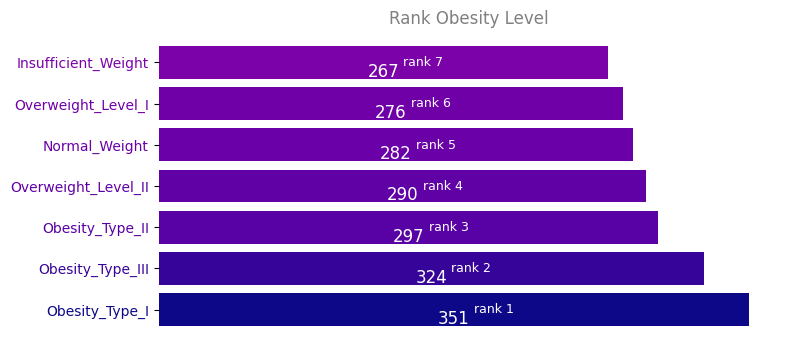

In [30]:
# Use the 'viridis' color palette with reversed colors
#colors = viridis(1 - obesity_counts / max(obesity_counts))
colors = plasma(1 - obesity_counts / max(obesity_counts))

# Create a horizontal bar chart
plt.figure(figsize=(8, 4))
bars = plt.barh(obesity_counts.index, obesity_counts, color=colors)

# Add value and rank inside each bar
for bar, count, color, street_name in zip(bars, obesity_counts, colors, obesity_counts.index):
    xval = bar.get_width()
    rank = obesity_counts.index.get_loc(street_name) + 1
    
    # Add value inside each bar
    plt.text(xval / 2, bar.get_y() + bar.get_height() / 2, f'{count}', ha='center', va='top', color='white', fontsize=12, fontweight=200)

    # Add rank text to the right of each bar
    plt.text(xval / 2 + 12, bar.get_y() + bar.get_height() / 2, f'rank {rank}', ha='left', va='center', color='white', fontsize=9, fontweight=200)

    # Set text color on the y-axis the same as the bar color
    plt.gca().yaxis.get_ticklabels()[list(obesity_counts.index).index(street_name)].set_color(color)

# Remove spines on the x and y axes
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Remove x-axis labels
plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

# Add title
plt.title('Rank Obesity Level', color='gray')

# Show the horizontal bar chart
plt.show()


### The relationship in dataframe

In [31]:
# Pisahkan kolom numerik dan kategorikal
numerical_columns = df.select_dtypes(include=['number'])
categorical_columns = df.select_dtypes(exclude=['number'])

# One-hot encoding untuk kolom kategorikal
categorical_columns = pd.get_dummies(categorical_columns, drop_first=True)

# Gabungkan kembali kolom numerik dan kategorikal
all_columns_corr = pd.concat([numerical_columns, categorical_columns], axis=1)

# Konversi kolom boolean menjadi integer
for column in all_columns_corr.select_dtypes(include=['bool']).columns:
    all_columns_corr[column] = all_columns_corr[column].astype(int)


In [32]:
# Contoh penggunaan:
positive_corr_df = filter_positive_corr(all_columns_corr, threshold=0.2)
positive_corr_df


,Feature 1,Feature 2,Correlation
8,height,gender_Male,0.626748
20,weight,obesity_level_Obesity_Type_III,0.557996
15,weight,family_history_overweight_yes,0.492969
23,vegetable_consumption,obesity_level_Obesity_Type_III,0.463916
4,height,weight,0.457468
19,weight,obesity_level_Obesity_Type_II,0.442523
17,weight,snacking_between_meals_Sometimes,0.406347
34,gender_Male,obesity_level_Obesity_Type_II,0.398544
40,family_history_overweight_yes,snacking_between_meals_Sometimes,0.316112
57,alcohol_consumption_Sometimes,obesity_level_Obesity_Type_III,0.304048


In [33]:
negative_corr_df = filter_negative_corr(all_columns_corr, threshold=-0.2)
negative_corr_df

,Feature 1,Feature 2,Correlation
22,alcohol_consumption_Sometimes,alcohol_consumption_no,-0.924964
14,snacking_between_meals_Frequently,snacking_between_meals_Sometimes,-0.829896
1,age,transportation_mode_Public_Transportation,-0.555532
9,gender_Male,obesity_level_Obesity_Type_III,-0.429553
2,weight,snacking_between_meals_Frequently,-0.378262
5,weight,obesity_level_Normal_Weight,-0.372760
17,snacking_between_meals_Sometimes,obesity_level_Normal_Weight,-0.316388
16,snacking_between_meals_Sometimes,snacking_between_meals_no,-0.312245
0,age,tech_usage_hours,-0.302927
11,family_history_overweight_yes,obesity_level_Normal_Weight,-0.297690


### The relationship with `obesity_level_Obesity_Type_I`

In [34]:
# Set the threshold for positive correlations
threshold = 0.05

# Find positive correlations with the specified threshold
positive_corrs1 = positive_correlations(all_columns_corr, 'obesity_level_Obesity_Type_I', threshold)
print(f"\nPositive correlations greater than {threshold}:\n", positive_corrs1)


Positive correlations greater than 0.05:
 family_history_overweight_yes       0.183412
alcohol_consumption_no              0.161518
snacking_between_meals_Sometimes    0.147595
high_caloric_food_yes               0.119296
age                                 0.108179
weight                              0.103232
water_intake                        0.079462
Name: obesity_level_Obesity_Type_I, dtype: float64


In [35]:
# Set the threshold for negative correlations
threshold = -0.05

# Find negative correlations with the specified threshold
negative_corrs1 = negative_correlations(all_columns_corr, 'obesity_level_Obesity_Type_I', threshold)
print(f"Negative correlations less than {threshold}:\n", negative_corrs1)

Negative correlations less than -0.05:
 vegetable_consumption                       -0.198006
obesity_level_Obesity_Type_III              -0.192764
obesity_level_Obesity_Type_II               -0.183160
obesity_level_Overweight_Level_II           -0.180636
obesity_level_Normal_Weight                 -0.177732
obesity_level_Overweight_Level_I            -0.175539
alcohol_consumption_Sometimes               -0.162658
main_meals_per_day                          -0.158418
snacking_between_meals_Frequently           -0.136287
calorie_monitoring_yes                      -0.086506
transportation_mode_Public_Transportation   -0.076660
transportation_mode_Walking                 -0.057982
snacking_between_meals_no                   -0.050701
Name: obesity_level_Obesity_Type_I, dtype: float64


# Splitting the dataset

## Setting seeds for reproducibility

In [36]:
import random
import os
#import keras

seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

## Setting the validation framework

In [37]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.15, random_state=seed_value, stratify=df["obesity_level"])
df_train, df_val = train_test_split(df_full_train, test_size=0.15, random_state=seed_value, stratify=df_full_train["obesity_level"])
len(df_train), len(df_test), len(df_val)

(1507, 314, 266)

## Removing specific columns and separating features from the target column

According to [the dataset's article](https://doi.org/10.1016/j.dib.2019.104344), the data was labeled using the following equation:

$Mass\ body\ index = \frac{weight}{{height}^2}$

Therefore, we need to delete at least a feature into previous equation.

cols_drop = ["obesity_level", "weight"]
X_full_train, y_full_train = df_full_train.drop(cols_drop, axis=1), df_full_train["obesity_level"]
X_train, y_train =  df_train.drop(cols_drop, axis=1), df_train["obesity_level"]
X_val, y_val =  df_val.drop(cols_drop, axis=1), df_val["obesity_level"]
X_test, y_test =  df_test.drop(cols_drop, axis=1), df_test["obesity_level"]

In [38]:
#cols_drop = ["obesity_level", "weight"]
cols_drop = ["obesity_level"]
X_full_train, y_full_train = df_full_train.drop(cols_drop, axis=1), df_full_train["obesity_level"]
X_train, y_train =  df_train.drop(cols_drop, axis=1), df_train["obesity_level"]
X_val, y_val =  df_val.drop(cols_drop, axis=1), df_val["obesity_level"]
X_test, y_test =  df_test.drop(cols_drop, axis=1), df_test["obesity_level"]

# Standardization

In [39]:
from sklearn.preprocessing import StandardScaler

numeric_cols = X_train.select_dtypes(exclude=["object"]).columns

ss = StandardScaler().set_output(transform="pandas")

ss.fit(X_train[numeric_cols])
ss.transform(X_train[numeric_cols])

,age,height,weight,vegetable_consumption,main_meals_per_day,water_intake,physical_activity_frequency,tech_usage_hours
2071,-0.859706,0.482798,1.583541,1.091725,0.378982,0.667080,-0.024754,0.010910
190,-0.679409,-1.084919,-1.165974,-0.803418,0.378982,-0.005343,-0.007330,-1.100719
1361,-0.996350,-0.153529,0.119958,0.593585,0.378982,-0.009926,0.410323,-0.329281
2109,0.011829,0.409630,1.759045,1.091725,0.378982,1.387169,0.157412,-0.135712
325,-0.520938,-1.620791,-1.090340,-0.803418,-2.235837,-1.639098,-0.007330,-1.100719
...,...,...,...,...,...,...,...,...
1357,-0.996350,0.891401,0.816134,-0.803418,-0.306828,1.066065,-0.007330,-0.820984
1013,4.906080,0.729214,-0.239784,-0.803418,0.378982,-0.005343,-0.007330,-1.100719
1971,-0.790813,1.243673,2.083181,1.091725,0.378982,1.137754,0.609467,0.157322
1265,-1.048027,0.399074,0.391538,-0.803418,0.378982,-0.005343,-1.191614,-0.716527


# One-hot encoding of features

In [40]:
from sklearn.feature_extraction import DictVectorizer

dict_X_full_train = X_full_train.to_dict("records")
dict_X_train = X_train.to_dict("records")
dict_X_val = X_val.to_dict("records")
dict_X_test = X_test.to_dict("records")

dv = DictVectorizer(sparse=False).set_output(transform="pandas")
dv.fit(dict_X_train)

dv.transform(dict_X_train).head()

,age,alcohol_consumption=Always,alcohol_consumption=Frequently,alcohol_consumption=Sometimes,alcohol_consumption=no,calorie_monitoring=no,calorie_monitoring=yes,family_history_overweight=no,family_history_overweight=yes,gender=Female,...,snacking_between_meals=no,tech_usage_hours,transportation_mode=Automobile,transportation_mode=Bike,transportation_mode=Motorbike,transportation_mode=Public_Transportation,transportation_mode=Walking,vegetable_consumption,water_intake,weight
0,18.862264,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.675076,0.0,0.0,0.0,1.0,0.0,3.000000,2.411582,128.705761
1,20.000000,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,2.000000,2.000000,56.000000
2,18.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.468483,0.0,0.0,0.0,1.0,0.0,2.737149,1.997195,90.004046
3,24.361936,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.586035,0.0,0.0,0.0,1.0,0.0,3.000000,2.852339,133.346641
4,21.000000,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,2.000000,1.000000,58.000000


# Creating a Pipeline

In [41]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class MyStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_cols):
        self.ss = StandardScaler().set_output(transform="pandas")
        self.numeric_cols = numeric_cols
        return

    def fit(self, X):
        self.ss.fit(X[self.numeric_cols])
        return self

    def transform(self, X):
        X[self.numeric_cols] = self.ss.transform(X[self.numeric_cols])
        return X.to_dict("records")

numeric_cols = X_train.select_dtypes(exclude=["object"]).columns
pipe = Pipeline([('ss', MyStandardScaler(numeric_cols=numeric_cols)), ('dv', DictVectorizer(sparse=False).set_output(transform="pandas"))])

X_train = pipe.fit_transform(X_train)
X_full_train = pipe.transform(X_full_train)
X_val = pipe.transform(X_val)
X_test = pipe.transform(X_test)

# Label encoding

In [42]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train)
y_full_train = le.transform(y_full_train)
y_train = le.transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

# Computing weigths for classes and samples

In [43]:
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight

class_full_weight = compute_class_weight(class_weight="balanced", classes=np.unique(y_full_train), y=y_full_train)
class_full_weight = dict(zip(np.unique(y_full_train), class_full_weight))

class_weight = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight = dict(zip(np.unique(y_train), class_weight))

sample_full_weights = compute_sample_weight(
    class_weight=class_full_weight,
    y=y_full_train
)

sample_weights = compute_sample_weight(
    class_weight=class_weight,
    y=y_train
)

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier,
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import numpy as np

# Training the models

In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss #, roc_auc_score
#from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [46]:
# 7. List of models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced"),
    "Random Forest": RandomForestClassifier(class_weight="balanced"),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss"),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "K-Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(probability=True, class_weight="balanced"),
    "Naive Bayes": GaussianNB(),
    "Ridge Classifier": RidgeClassifier(class_weight="balanced"),
    "Extra Trees": ExtraTreesClassifier(class_weight="balanced"),
    "CatBoost": CatBoostClassifier(verbose=0),
    "LightGBM": LGBMClassifier(class_weight="balanced"),
}

In [47]:
# Fungsi untuk melatih model dan menghitung skor
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    
    # Evaluasi metrik
    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions, average='weighted')
    recall = recall_score(y_val, predictions, average='weighted')
    f1 = f1_score(y_val, predictions, average='weighted')
    
    # Log Loss untuk multi-class
    try:
        # Menggunakan predict_proba untuk mendapatkan probabilitas dan menghitung log loss
        log_loss_value = log_loss(y_val, model.predict_proba(X_val))
    except Exception as e:
        log_loss_value = 'N/A'
    
    return accuracy, precision, recall, f1, log_loss_value


In [48]:
# Mengumpulkan hasil evaluasi model
results = {}

# Evaluasi setiap model
for name, model in models.items():
    try:
        accuracy, precision, recall, f1, log_loss_value = train_and_evaluate_model(model, X_train, y_train, X_val, y_val)
        results[name] = (accuracy, precision, recall, f1, log_loss_value)
        print(f"{name} - Accuracy: {accuracy:.5f}, Precision: {precision:.5f}, Recall: {recall:.5f}, F1: {f1:.5f}, Log Loss: {log_loss_value}")
    except Exception as e:
        print(f"Error in {name}: {e}")



Logistic Regression - Accuracy: 0.84962, Precision: 0.85248, Recall: 0.84962, F1: 0.84915, Log Loss: 0.42225767576105244
Decision Tree - Accuracy: 0.94361, Precision: 0.94490, Recall: 0.94361, F1: 0.94395, Log Loss: 2.032536845250968
Random Forest - Accuracy: 0.89098, Precision: 0.90225, Recall: 0.89098, F1: 0.89332, Log Loss: 0.3432898419477639
XGBoost - Accuracy: 0.96992, Precision: 0.97178, Recall: 0.96992, F1: 0.97014, Log Loss: 0.1323508561033439
Gradient Boosting - Accuracy: 0.95113, Precision: 0.95464, Recall: 0.95113, F1: 0.95197, Log Loss: 0.13539605415610922
AdaBoost - Accuracy: 0.43609, Precision: 0.28704, Recall: 0.43609, F1: 0.32386, Log Loss: 1.9216186086397493
K-Neighbors - Accuracy: 0.85338, Precision: 0.84547, Recall: 0.85338, F1: 0.83956, Log Loss: 2.396005369616483
Support Vector Machine - Accuracy: 0.89098, Precision: 0.89281, Recall: 0.89098, F1: 0.89161, Log Loss: 0.24345943258436636
Naive Bayes - Accuracy: 0.56391, Precision: 0.60190, Recall: 0.56391, F1: 0.51407

In [49]:
# Mengurutkan model berdasarkan accuracy
sorted_results_accuracy = sorted(results.items(), key=lambda x: x[1][0], reverse=True)

# Menampilkan 3 model terbaik berdasarkan accuracy
print("\nTop 3 Models in Accuracy:")
for i in range(3):
    name, metrics = sorted_results_accuracy[i]
    print(f"{i+1}. {name} - Accuracy: {metrics[0]:.5f}, Precision: {metrics[1]:.5f}, Recall: {metrics[2]:.5f}, F1: {metrics[3]:.5f}, Log Loss: {metrics[4]:.5f}")

# Memfilter hasil dengan Log Loss yang valid (numerik)
valid_results_log_loss = {name: metrics for name, metrics in results.items() if isinstance(metrics[4], (int, float))}

# Mengurutkan model berdasarkan Log Loss (nilai lebih rendah lebih baik)
sorted_results_log_loss = sorted(valid_results_log_loss.items(), key=lambda x: x[1][4])

# Menampilkan 3 model terbaik berdasarkan Log Loss
print("\nTop 3 Models in Log Loss:")
for i in range(3):
    name, metrics = sorted_results_log_loss[i]
    print(f"{i+1}. {name} - Log Loss: {metrics[4]:.5f}, Precision: {metrics[1]:.5f}, Recall: {metrics[2]:.5f}, F1: {metrics[3]:.5f}, Accuracy: {metrics[0]:.5f}")



Top 3 Models in Accuracy:
1. XGBoost - Accuracy: 0.96992, Precision: 0.97178, Recall: 0.96992, F1: 0.97014, Log Loss: 0.13235
2. LightGBM - Accuracy: 0.95865, Precision: 0.96349, Recall: 0.95865, F1: 0.95900, Log Loss: 0.16739
3. Gradient Boosting - Accuracy: 0.95113, Precision: 0.95464, Recall: 0.95113, F1: 0.95197, Log Loss: 0.13540

Top 3 Models in Log Loss:
1. CatBoost - Log Loss: 0.13115, Precision: 0.95485, Recall: 0.95113, F1: 0.95191, Accuracy: 0.95113
2. XGBoost - Log Loss: 0.13235, Precision: 0.97178, Recall: 0.96992, F1: 0.97014, Accuracy: 0.96992
3. Gradient Boosting - Log Loss: 0.13540, Precision: 0.95464, Recall: 0.95113, F1: 0.95197, Accuracy: 0.95113


## Find best parameter for Top 3 Models in Log Loss

## CatBoost Classifier

In [50]:
# Objective function for CatBoostClassifier (Multiclass)
def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, step=0.01),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'loss_function': 'MultiClass',  # Menggunakan MultiClass untuk klasifikasi multikelas
        'random_state': 42
    }

    # Create a CatBoostClassifier model with the specified parameters
    model = CatBoostClassifier(**params, verbose=0)
    model.fit(X_train, y_train)

    # Predict on the validation data
    y_pred_proba = model.predict_proba(X_val)  # Get probabilities for all classes

    # Calculate the log loss or any other appropriate evaluation metric for multiclass
    log_loss_value = log_loss(y_val, y_pred_proba)
    return log_loss_value

# Create study with TPESampler and fixed seed
study_catboost = optuna.create_study(
    direction='minimize', 
    sampler=optuna.samplers.TPESampler(seed=42)  # Set seed here
)

# Run Optuna for CatBoostClassifier
study_catboost.optimize(objective_catboost, n_trials=50)

# Best results for CatBoostClassifier
print("Best parameters for CatBoostClassifier:")
print(study_catboost.best_trial.params)
print("Best Log Loss for CatBoostClassifier: {:.5f}".format(study_catboost.best_value))


Best parameters for CatBoostClassifier:
{'iterations': 434, 'depth': 4, 'learning_rate': 0.15000000000000002, 'l2_leaf_reg': 0.002473403654859812, 'random_strength': 0.006477967147195818, 'bagging_temperature': 0.7573147661433607, 'border_count': 220}
Best Log Loss for CatBoostClassifier: 0.08668


## XGB Classifier

In [51]:
# Objective function for XGBoost (Multiclass)
def objective_xgboost(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, step=0.01),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 1.0, log=True),
        'objective': 'multi:softmax',  # Multiclass classification
        'num_class': len(np.unique(y_train)),  # Number of classes
        'random_state': 42
    }

    # Create XGBClassifier with the specified parameters
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)

    # Predict on the validation data
    y_pred_proba = model.predict_proba(X_val)  # Get probabilities for all classes

    # Calculate log loss for multiclass classification
    log_loss_value = log_loss(y_val, y_pred_proba)
    return log_loss_value

# Create study with TPESampler and fixed seed
study_xgboost = optuna.create_study(
    direction='minimize', 
    sampler=optuna.samplers.TPESampler(seed=42)  # Set seed here
)

# Run Optuna for XGBoost
study_xgboost.optimize(objective_xgboost, n_trials=50)

# Best results for XGBoost
print("Best parameters for XGBoost:")
print(study_xgboost.best_trial.params)
print("Best Log Loss for XGBoost: {:.5f}".format(study_xgboost.best_value))


Best parameters for XGBoost:
{'n_estimators': 951, 'max_depth': 3, 'learning_rate': 0.11, 'subsample': 0.8911773706382694, 'colsample_bytree': 0.9489169222926844, 'gamma': 0.045198786459039825, 'reg_alpha': 0.001761075078473816, 'reg_lambda': 0.1555280160733892}
Best Log Loss for XGBoost: 0.10310


## Gradient Boosting (Multiclass)

In [52]:
# Objective function for Gradient Boosting (Multiclass)
def objective_gradient_boosting(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, step=0.01),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'random_state': 42
    }

    # Create GradientBoostingClassifier with the specified parameters
    model = GradientBoostingClassifier(**params)
    model.fit(X_train, y_train)

    # Predict on the validation data
    y_pred_proba = model.predict_proba(X_val)  # Get probabilities for all classes

    # Calculate log loss for multiclass classification
    log_loss_value = log_loss(y_val, y_pred_proba)
    return log_loss_value

# Create study with TPESampler and fixed seed
study_gradient_boosting = optuna.create_study(
    direction='minimize', 
    sampler=optuna.samplers.TPESampler(seed=42)  # Set seed here
)

# Run Optuna for Gradient Boosting
study_gradient_boosting.optimize(objective_gradient_boosting, n_trials=50)

# Best results for Gradient Boosting
print("Best parameters for Gradient Boosting:")
print(study_gradient_boosting.best_trial.params)
print("Best Log Loss for Gradient Boosting: {:.5f}".format(study_gradient_boosting.best_value))


Best parameters for Gradient Boosting:
{'n_estimators': 408, 'max_depth': 4, 'learning_rate': 0.02, 'subsample': 0.5545328448543362, 'min_samples_split': 9, 'min_samples_leaf': 1}
Best Log Loss for Gradient Boosting: 0.14589


## Choose the Best Model

In [53]:
#from sklearn.metrics import accuracy_score, log_loss

# Ambil parameter terbaik dari studi Optuna
best_params_catboost = study_catboost.best_trial.params

# Buat model CatBoostClassifier dengan parameter terbaik
final_catboost = CatBoostClassifier(**best_params_catboost, verbose=0)

# Latih model dengan data training
final_catboost.fit(X_train, y_train)

# Prediksi pada data validasi
y_pred_proba_catboost = final_catboost.predict_proba(X_val)  # Mendapatkan probabilitas untuk semua kelas

# Evaluasi dengan Log Loss untuk klasifikasi multiclass
final_log_loss_catboost = log_loss(y_val, y_pred_proba_catboost)

# Menghitung akurasi untuk evaluasi klasifikasi
y_pred_catboost = final_catboost.predict(X_val)
final_accuracy_catboost = accuracy_score(y_val, y_pred_catboost)

# Output hasil
print("CatBoost Accuracy: {:.5f}".format(final_accuracy_catboost))
print("Final Log Loss for CatBoost: {:.5f}".format(final_log_loss_catboost))


CatBoost Accuracy: 0.96617
Final Log Loss for CatBoost: 0.09900


In [54]:
# Ambil parameter terbaik dari studi Optuna
best_params_xgboost = study_xgboost.best_trial.params

# Buat model XGBClassifier dengan parameter terbaik
final_xgboost = XGBClassifier(**best_params_xgboost, objective='multi:softmax', num_class=len(np.unique(y_train)), use_label_encoder=False)

# Latih model dengan data training
final_xgboost.fit(X_train, y_train)

# Prediksi pada data validasi
y_pred_proba_xgboost = final_xgboost.predict_proba(X_val)  # Mendapatkan probabilitas untuk semua kelas

# Evaluasi dengan Log Loss untuk klasifikasi multiclass
final_log_loss_xgboost = log_loss(y_val, y_pred_proba_xgboost)

# Menghitung akurasi untuk evaluasi klasifikasi
y_pred_xgboost = final_xgboost.predict(X_val)
final_accuracy_xgboost = accuracy_score(y_val, y_pred_xgboost)

# Output hasil
print("XGBoost Accuracy: {:.5f}".format(final_accuracy_xgboost))
print("Final Log Loss for XGBoost: {:.5f}".format(final_log_loss_xgboost))


XGBoost Accuracy: 0.95865
Final Log Loss for XGBoost: 0.11697


In [55]:
# Ambil parameter terbaik dari studi Optuna untuk Gradient Boosting
best_params_gradient_boosting = study_gradient_boosting.best_trial.params

# Buat model GradientBoostingClassifier dengan parameter terbaik
final_gradient_boosting = GradientBoostingClassifier(**best_params_gradient_boosting)

# Latih model dengan data training
final_gradient_boosting.fit(X_train, y_train)

# Prediksi pada data validasi
y_pred_proba_gradient_boosting = final_gradient_boosting.predict_proba(X_val)  # Mendapatkan probabilitas untuk semua kelas

# Evaluasi dengan Log Loss untuk klasifikasi multiclass
final_log_loss_gradient_boosting = log_loss(y_val, y_pred_proba_gradient_boosting)

# Menghitung akurasi untuk evaluasi klasifikasi
y_pred_gradient_boosting = final_gradient_boosting.predict(X_val)
final_accuracy_gradient_boosting = accuracy_score(y_val, y_pred_gradient_boosting)

# Output hasil
print("Gradient Boosting Accuracy: {:.5f}".format(final_accuracy_gradient_boosting))
print("Final Log Loss for Gradient Boosting: {:.5f}".format(final_log_loss_gradient_boosting))


Gradient Boosting Accuracy: 0.94737
Final Log Loss for Gradient Boosting: 0.14723


In [56]:
models = ['CatBoost', 'XGBoost', 'Gradient Boosting']

# Log loss values for each model
all_log_loss = [final_log_loss_catboost, final_log_loss_xgboost, final_log_loss_gradient_boosting]

# Accuracy scores for each model
all_scores = [
    final_catboost.score(X_val, y_val),
    final_xgboost.score(X_val, y_val),
    final_gradient_boosting.score(X_val, y_val)
]

# Find the smallest log loss (lower is better) and the biggest accuracy score (higher is better)
smallest_log_loss = min(all_log_loss)
biggest_score = max(all_scores)

# Find the index of the smallest log loss and the biggest score
smallest_log_loss_index = all_log_loss.index(smallest_log_loss)
biggest_score_index = all_scores.index(biggest_score)

# Print the model names with the smallest log loss and the biggest accuracy score
print("Smallest log_loss: {:.5f} is model {}".format(smallest_log_loss, models[smallest_log_loss_index]))
print("Biggest Score (Accuracy): {:.5f} is model {}".format(biggest_score, models[biggest_score_index]))


Smallest log_loss: 0.09900 is model CatBoost
Biggest Score (Accuracy): 0.96617 is model CatBoost


In [57]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold


## Do Cross-Validation

In [58]:
# Define models for cross-validation (use actual models, not log loss values)
models = {
    'CatBoost': final_catboost,
    'XGBoost': final_xgboost,
    'Gradient Boosting': final_gradient_boosting
}

# Initialize dictionaries to store results
cv_scores = {}
log_loss_values = {}

# Perform manual cross-validation for each model
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    fold_log_losses = []
    
    # Loop through each fold
    for train_index, val_index in kf.split(X_val):
        # Use .iloc[] to select rows based on indices for X and standard indexing for y
        X_train, X_val_fold = X_val.iloc[train_index], X_val.iloc[val_index]
        y_train, y_val_fold = y_val[train_index], y_val[val_index]  # Use array indexing here
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict probabilities (needed for log loss)
        y_val_pred_proba = model.predict_proba(X_val_fold)
        
        # Calculate log loss for this fold
        # Get all possible class labels (union of train and validation labels)
        all_classes = np.unique(np.concatenate((y_train, y_val_fold)))
        # Calculate log loss for this fold
        fold_log_loss = log_loss(y_val_fold, y_val_pred_proba, labels=all_classes)
        #fold_log_loss = log_loss(y_val_fold, y_val_pred_proba)
        fold_log_losses.append(fold_log_loss)
    
    # Average log loss across all folds
    cv_scores[model_name] = np.mean(fold_log_losses)
    log_loss_values[model_name] = fold_log_losses

# Find the model with smallest log_loss (lower is better)
smallest_log_loss_model = min(cv_scores, key=cv_scores.get)

# For model with the biggest score, use the `score()` method on actual models
biggest_score_model = max(models, key=lambda model_name: models[model_name].score(X_val, y_val))

# Print the results
print("Cross-Validation Results:")
for model_name, avg_log_loss in cv_scores.items():
    print(f"{model_name}: Average log_loss = {avg_log_loss:.5f}")

print("\nSmallest log_loss: {:.5f} is model {}".format(cv_scores[smallest_log_loss_model], smallest_log_loss_model))
print("Biggest Score: {:.5f} is model {}".format(models[biggest_score_model].score(X_val, y_val), biggest_score_model))


Cross-Validation Results:
CatBoost: Average log_loss = 0.49407
XGBoost: Average log_loss = 0.51192
Gradient Boosting: Average log_loss = 0.49576

Smallest log_loss: 0.49407 is model CatBoost
Biggest Score: 0.98872 is model CatBoost


### CatBoost Classifier is the best model for this data

## Save the Model

In [61]:
import cloudpickle

with open('obesity-levels-model_catboost.bin', 'wb') as f_out:
    cloudpickle.dump((pipe, le, final_catboost), f_out)